<a href="https://colab.research.google.com/github/wumouyan/Colaboratory-Notes/blob/master/bds2_b1_acq_publish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beidou B1 

## Open file

Fetch recorded antenna data from file in Google Drive.


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
file_id = '1bcUxiT0OKDERT_9jhBibEXReKXjBSVPY'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data');

## Read file

Read the recorded antenna data file and do a very simple sanity check by plotting the I/Q values in a histogram. They should be balanced, because there can not be an offset in the received signal. This verifies the correct functionality of the signal sampling.

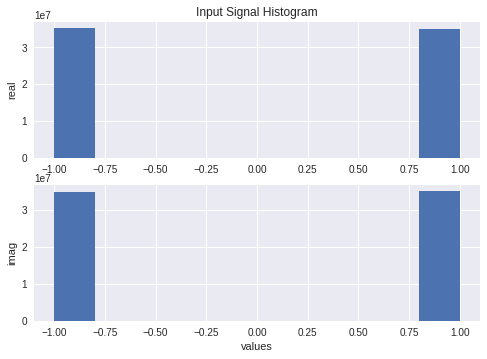

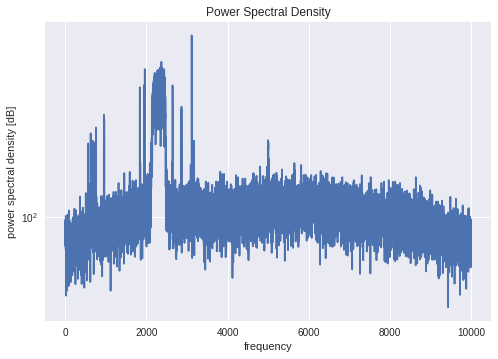

In [0]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt

# Parameters Signal 
FCHIP = 2.046e6
FCENTER = 1561.098e6
CODE_LEN = 2046
CODE_PERIOD = CODE_LEN / FCHIP

# Parameters File
FS = 10e6
FCENTER_REC=1560e6
FIF = FCENTER - FCENTER_REC
INTERLEAVED = 1
SAMP_PER_MS = int(round(FS / 1000))

# Parameters Simulation
NUM_MS = 7000
NUM_SAMPLES = NUM_MS * SAMP_PER_MS
NUM_SAMPLE_SKIP = 4660

x = np.fromfile('data', dtype='int8', 
                count=(INTERLEAVED+1)*(NUM_SAMPLES + NUM_SAMPLE_SKIP))
x = x[2*NUM_SAMPLE_SKIP:]

# Separate interleaved samples for I/Q
i = x[0::2]
q = x[1::2]

plt.subplot(2,1,1)
plt.title('Input Signal Histogram')
plt.hist(i)
plt.ylabel('real')
plt.subplot(2,1,2)
plt.hist(q)
plt.xlabel('values')
plt.ylabel('imag')
plt.show()

# Compute complex values and reshape
sig = i + 1j * q
sig = sig.reshape((NUM_MS, SAMP_PER_MS))

# Average spectrum for 10 ms 
psd_avg = 0
for k in range(0,10):
  psd_avg += fft.fftshift(abs(fft.fft(sig[k,:])))
psd_avg /= 10.

plt.semilogy(psd_avg)
plt.title('Power Spectral Density')
plt.ylabel('power spectral density [dB]')
plt.xlabel('frequency')
plt.show()

## Generate Codes 

Codes are generated according to the ICD. The code needs to be up-sampled to 10 Msps, to match the sampling rate FS of the incoming signal. 

In [0]:
b1i_g2_taps = {
   1: (1,3),    2: (1,4),    3: (1,5),    4: (1,6),
   5: (1,8),    6: (1,9),    7: (1,10),   8: (1,11),
   9: (2,7),   10: (3,4),   11: (3,5),   12: (3,6),
  13: (3,8),   14: (3,9),   15: (3,10),  16: (3,11),
  17: (4,5),   18: (4,6),   19: (4,8),   20: (4,9),
  21: (4,10),  22: (4,11),  23: (5,6),   24: (5,8),
  25: (5,9),   26: (5,10),  27: (5,11),  28: (6,8),
  29: (6,9),   30: (6,10),  31: (6,11),  32: (8,9),
  33: (8,10),  34: (8,11),  35: (9,10),  36: (9,11),
  37: (10,11)
}

def b1i(prn):
    g1 = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])
    g2 = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

    tab_a, tab_b = b1i_g2_taps[prn] 
    tab_a -= 1
    tab_b -= 1
    
    output = np.empty(CODE_LEN, dtype=int)

    for chip in range(CODE_LEN):
      output[chip] = g1[10] ^ (g2[tab_a] ^ g2[tab_b])
      g1_new = g1[0] ^ g1[6] ^ g1[7] ^ g1[8] ^ g1[9] ^ g1[10]
      g2_new = g2[0] ^ g2[1] ^ g2[2] ^ g2[3] ^ g2[4] ^ g2[7] ^ g2[8] ^ g2[10]

      g1 = np.roll(g1, 1)
      g1[0] = g1_new 
      g2 = np.roll(g2, 1)
      g2[0] = g2_new
    return output

# Generate codes
codes = [(1 - 2 * b1i(prn)) for prn in range(1,38)]

# Resample codes
idx = np.arange(SAMP_PER_MS)
np.floor(idx * FCHIP / FS, out=idx, casting='unsafe')

resamp_codes = []
for code in codes:
  resamp_codes.append(code[idx])
  

## Acquisition

This is done through a parallel acquisition approach, using FFT for the correlation. 

In [0]:
# Parameters
THRESHOLD = 500
DOPP_MAX = 5000
DOPP_STEP = 600

t = np.linspace(0, CODE_PERIOD, num=SAMP_PER_MS, endpoint=False)
candidates = []

for i, code in enumerate(resamp_codes):
  for freq in range (-DOPP_MAX, DOPP_MAX, DOPP_STEP):
    baseband =(sig[0,:] * np.exp(-2*np.pi*1j*t*(FIF+freq)))
    xcorr = abs(fft.ifft(fft.fft(baseband) * np.conj(fft.fft(code))))
    xcorr_max = max(xcorr)
    xcorr_max_idx = np.argmax(xcorr)
    if xcorr_max >= THRESHOLD:
      candidates.append((i+1, freq, xcorr_max_idx, xcorr_max))

# Print acquired satellites
print('prn\tdoppler \tsample_idx\tcorr value')
for c in candidates:
  print('%2d \t %5d \t\t %4d \t\t %5.2f' % (c[0],c[1],c[2],c[3]))


prn	doppler 	sample_idx	corr value
 1 	  -800 		 3602 		 507.39
 1 	  1600 		 5613 		 530.61
19 	  1600 		 2200 		 520.79
19 	  2200 		 2200 		 844.51
23 	  1600 		 3092 		 519.49
29 	  -200 		    6 		 883.56
29 	   400 		    6 		 813.16


## Tracking

Doppler recovery is done by looking at phase drift.

We choose to track satellite PRN 29, from looking at the acquisition results. 
It was acquired at a doppler of -200 and +400 Hz, so we kick off tracking with a doppler of 100 Hz.

In [0]:
# Parameter
SAT = 29
ALPHA_LP = 0.1
DOPP_FREQ_INIT = 100

dopp_freq = [DOPP_FREQ_INIT]
xcorr_max = {}
a_diff_vals = {}
trk_sample_idx = {}
phase_init = 0
bits = [1]

code = resamp_codes[SAT-1]

# Loop through single milliseconds
for ms in range(NUM_MS):

  # Modulate to baseband with current estimated doppler
  phase = 2*np.pi*(FIF+dopp_freq[-1])
  baseband = sig[ms,:] * np.exp(-1j*(phase_init + phase*t))
  phase_init = phase_init + phase * CODE_PERIOD

  # Cross-correlate and get complex maximum
  xcorr = fft.ifft(fft.fft(baseband) * np.conj(fft.fft(code)))
  xcorr_max_idx = np.argmax(abs(xcorr))
  xcorr_max[ms] = xcorr[xcorr_max_idx]
  trk_sample_idx[ms] = xcorr_max_idx

  # Calculate phase difference from last ms
  if ms >= 1:
    a0 = np.angle(xcorr_max[ms-1]) / (2 * np.pi)
    a1 = np.angle(xcorr_max[ms]) / (2 * np.pi)
    a_diff = a1 - a0
    
    # Limit rotation to +/- 0.5 cycle
    if a_diff > +0.5:
      a_diff -= 1.0
    if a_diff < -0.5:
      a_diff += 1.0

    # Determine databit transition
    flip = 1
    if a_diff > +0.25:
      a_diff -= 0.5
      flip = -1
    elif a_diff < -0.25:
      a_diff += 0.5
      flip = -1
      
    bits.append(bits[-1] * flip)
      
    a_diff_vals[ms] = a_diff
    target_dopp_freq = dopp_freq[-1] + (a_diff / CODE_PERIOD)
    
    new_doppler = (1-ALPHA_LP)*dopp_freq[-1] + (ALPHA_LP)*(target_dopp_freq)
    dopp_freq.append(new_doppler)
    

## Tracking Results

Initial Doppler:  100.00 Hz
Expected Doppler: 156.11 Hz
Tracked Doppler:  53.16 Hz


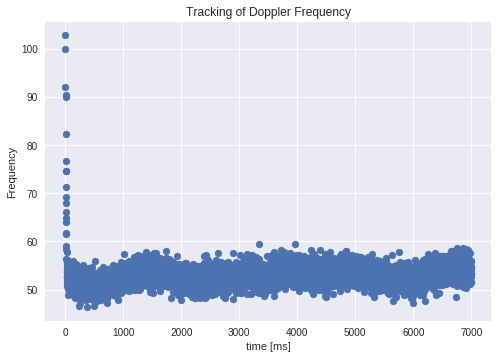

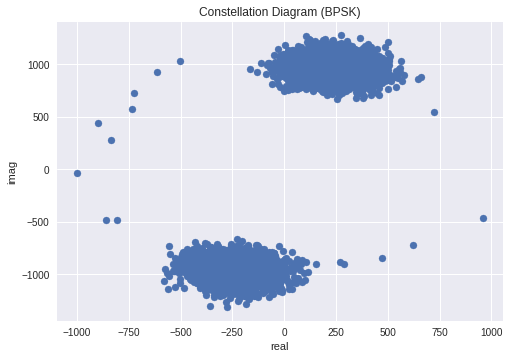

In [0]:
# Calculate expected doppler by drift of samples per second
chip_sample_diff = abs(trk_sample_idx[int(1/CODE_PERIOD)]-trk_sample_idx[0])
dopp_expect = chip_sample_diff * FCENTER / FS

print('Initial Doppler:  %.2f Hz' % DOPP_FREQ_INIT)
print('Expected Doppler: %.2f Hz' % dopp_expect)
print('Tracked Doppler:  %.2f Hz' % dopp_freq[-1])

plt.figure()  
plt.title('Tracking of Doppler Frequency')
plt.ylabel('Frequency')
plt.xlabel('time [ms]')
plt.scatter(range(NUM_MS),dopp_freq)
plt.show()

# Transform complex values to cartesian
x = [n.real for n in xcorr_max.values()]
y = [n.imag for n in xcorr_max.values()]

# Plots
plt.scatter(x, y)
plt.title('Constellation Diagram (BPSK)')
plt.ylabel('imag')
plt.xlabel('real')
plt.show()

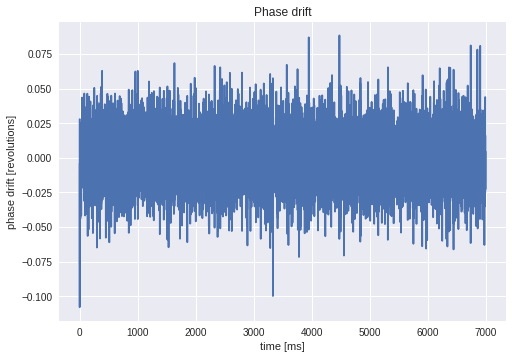

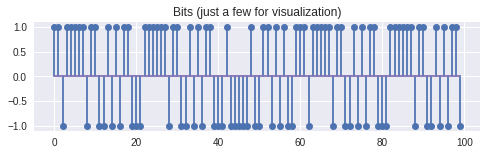

In [0]:
plt.figure()
plt.title('Phase drift')
plt.ylabel('phase drift [revolutions]')
plt.xlabel('time [ms]')
plt.plot(a_diff_vals.values())
plt.show()

plt.figure(figsize=(8,2))
plt.title('Bits (just a few for visualization)')
plt.stem(bits[:100])
plt.show()

## Bit Synchronization

The B1 pilot signal contains a secondary code that is a Neumann-Hoffmann with 20 bit length (NH20).
A secondary code chip overlays a primary code period.

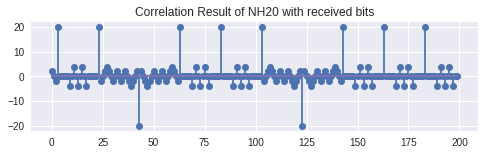

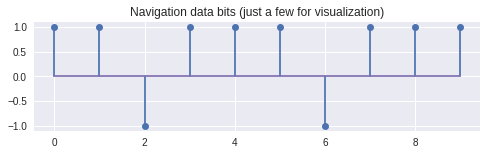

In [0]:
NH20 = np.array([0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,0,1,1,1,0])
NH20 = 1 - 2 * NH20

# Correlate NH20 with received bits 
data_corr = []
for k in range(len(bits)-len(NH20)):
  data_corr.append( np.dot(bits[k : k+20], NH20) )

plt.figure(figsize=(8,2))
plt.title('Correlation Result of NH20 with received bits')
plt.stem(data_corr[:200])
plt.show()

# Filter correlation results
THRESHOLD = 17
start_index = np.flatnonzero(np.abs(data_corr) > THRESHOLD)

data_bits = np.sign([data_corr[i] for i in start_index])

plt.figure(figsize=(8,2))
plt.title('Navigation data bits (just a few for visualization)')
plt.stem(data_bits[:10])
plt.show()


## Analyzing the received bits

In particular: Finding the preamble.

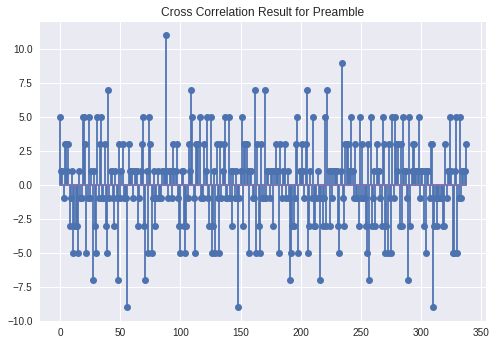

In [0]:
preamble = np.array([1,1,1,0,0,0,1,0,0,1,0])
preamble = 1 - 2 * preamble

preamble_corr = []
for k in range(len(data_bits)-len(preamble)):
  preamble_corr.append( np.dot(data_bits[k : k+len(preamble)], preamble) )
  
plt.stem(preamble_corr)
plt.title('Cross Correlation Result for Preamble')
plt.show()


One perfect preamble match was found. With a longer file, we would see two in a distance of 300 bit, which is 6 seconds at a data rate of 50Hz (20 ms/chip). 


## Correlation Basics

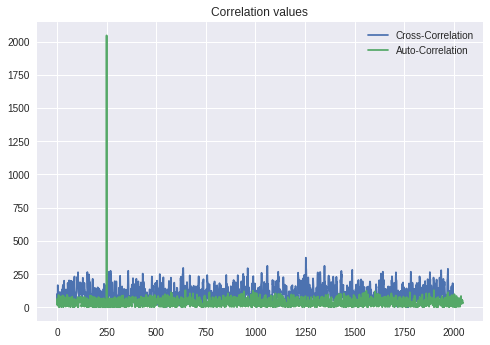

In [0]:
###################################################
# Autocorrelation with FFT method
SHIFT = 250
code = (1 - 2 * b1i(1))
autocorr = abs(fft.ifft(fft.fft(np.roll(code, SHIFT)) * np.conj(fft.fft(code))))

###################################################
# Cross-correlation code and received signal
PRN = 29
FREQ = 50

# Bring received signal to baseband
t = np.linspace(0, 0.001, num=SAMP_PER_MS, endpoint=False)
baseband = sig[0,:] * np.exp(-2*np.pi*1j*t*(FIF+FREQ))

# Correlate signal with code
xcorr = abs(fft.ifft(fft.fft(baseband) * np.conj(fft.fft(resamp_codes[PRN-1]))))

###################################################

# Plot
plt.plot(xcorr[:2000])
plt.plot(autocorr)

plt.title('Correlation values')
plt.legend(['Cross-Correlation','Auto-Correlation'])
plt.show()

The result of the auto-correlation is higher, because is correlates perfectly for all bits. The correlation peak therefor is the sum of all bits, which is 2046 in this case.  
  
In the case of cross-correlation, the signal to correlate with is noisy, so it does not correlate perfectly. Thus, the correlation peak is lower. However, the peak is still significantly higher than the noise correlation values.

## Conclusion

We could show the complete chain of signal processing from raw antenna data to navigation data bits.
